In [131]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import PIL.Image as Image

from datetime import datetime
import antropy as ant

# tmp unused
from scipy.fft import fft, fftfreq
from scipy.signal import blackman, hamming, detrend
import scipy.signal as signal

In [2]:
path_root = '/Users/zhangchao/Downloads/data_tmp/0428'
fs = 1000

In [111]:
data_info = {}
exp = os.listdir(path_root)
exp.remove('.DS_Store')
exp.sort()
exp

['093433', '102044', '111744', '115536', '123110']

In [112]:
# get eeg start time and end time
eeg_start_time = []
eeg_end_time = []
for i in range(len(exp)):
    with open('{}/{}/info.txt'.format(path_root, exp[i]), 'r') as f:
        for line in f.readlines():
            line = line.strip('\n')
            if '开始时间' in line:
                eeg_start_time.append(line[-20:-1])
                break
    with open('{}/{}/info.txt'.format(path_root, exp[i]), 'r') as f:
        for line in f.readlines():
            line = line.strip('\n')
            if '结束时间' in line:
                eeg_end_time.append(line[-20:-1])
                break
print('eeg_start_time', eeg_start_time)
print('eeg_end_time', eeg_end_time)

eeg_start_time ['2023-04-28 09:34:42', '2023-04-28 10:20:51', '2023-04-28 11:17:56', '2023-04-28 11:55:36', '2023-04-28 12:31:10']
eeg_end_time ['2023-04-28 09:58:22', '2023-04-28 10:53:15', '2023-04-28 11:38:57', '2023-04-28 12:12:48', '2023-04-28 13:00:50']


path_tmp /Users/zhangchao/Downloads/data_tmp/0428/093433/EP
csv_list ['/Users/zhangchao/Downloads/data_tmp/0428/093433/EP/CA_46_B1_BF_97_28-1.csv', '/Users/zhangchao/Downloads/data_tmp/0428/093433/EP/CA_46_B1_BF_97_28-2.csv', '/Users/zhangchao/Downloads/data_tmp/0428/093433/EP/CA_46_B1_BF_97_28-3.csv', '/Users/zhangchao/Downloads/data_tmp/0428/093433/EP/CA_46_B1_BF_97_28-4.csv', '/Users/zhangchao/Downloads/data_tmp/0428/093433/EP/CA_46_B1_BF_97_28-5.csv']
eeg.shape (5, 1408704)
duration(s): 1408.704
<Info | 7 non-empty values
 bads: []
 ch_names: EEG0, EEG1, EEG2, EEG3, EEG4
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 1000.0 Hz
>
Creating RawArray with float64 data, n_channels=5, n_times=1408704
    Range : 0 ... 1408703 =      0.000 ...  1408.703 secs
Ready.


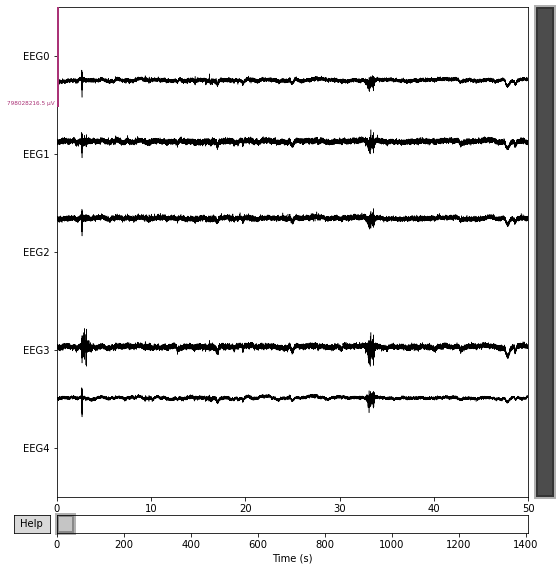

Effective window size : 2.048 (s)


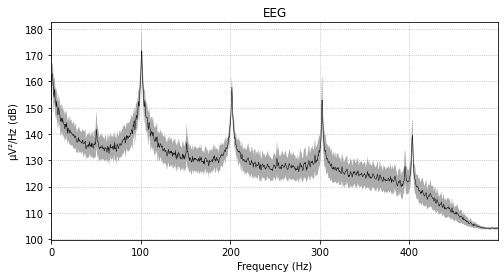

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_7581/167517867.py:53: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


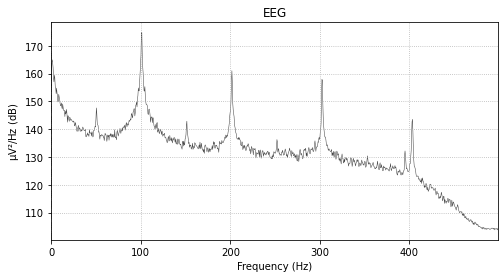

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_7581/167517867.py:53: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


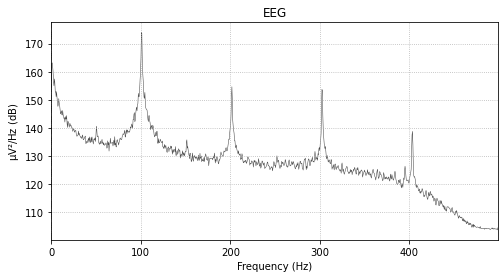

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_7581/167517867.py:53: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


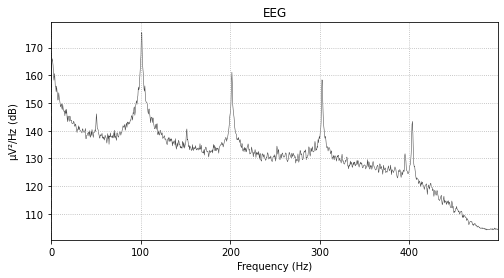

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_7581/167517867.py:53: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


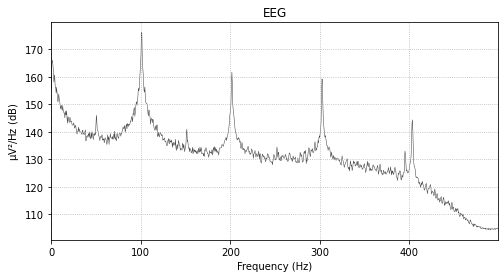

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_7581/167517867.py:53: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


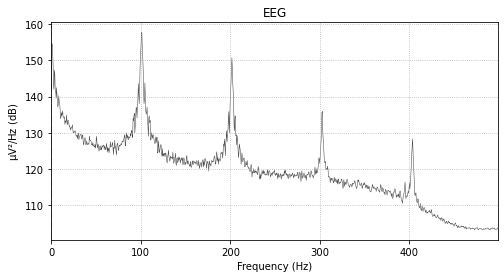

In [116]:
data_info = {}

# for i in range(len(exp)):
for i in range(1):
    path_tmp = '{}/{}/EP'.format(path_root, exp[i])
    print('path_tmp', path_tmp)
    if os.path.exists(path_tmp):
        csv_list = []
        for root, _, filenames in os.walk(path_tmp):
            for filename in fnmatch.filter(filenames, '*.csv'):
                csv_list.append(os.path.join(root, filename))
        csv_list.sort()
        print('csv_list', csv_list)
    else:
        continue

    # read data of NeuraMatrix
    eeg = []
    for c in range(len(csv_list)):
        df = pd.read_csv('{}'.format(csv_list[c]), header=None)
        eeg.append(df[2])
    eeg = np.array(eeg)

    # eeg -= eeg[0,:]
    # eeg -= np.mean(eeg[[0,1,3,4], :], axis=0)

    print('eeg.shape', eeg.shape)
    print('duration(s):', eeg.shape[1]/fs)
    data_info['exp{}_duration'.format(i)] = eeg.shape[1]/fs
    tmp = datetime.strptime(eeg_end_time[i], '%Y-%m-%d %H:%M:%S') - datetime.strptime(eeg_start_time[i], '%Y-%m-%d %H:%M:%S')
    data_info['exp{}_pack_loss'.format(i)] = tmp.seconds - eeg.shape[1]/fs
    # some case are not 5 channel
    ch_num = eeg.shape[0]
    # for mne object
    ch_names = ['EEG{}'.format(i) for i in range(ch_num)]
    ch_types = ['eeg' for i in range(ch_num)]
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=fs)
    print(info)

    data_info['exp{}_chnum'.format(i)] = eeg.shape[0]
    data_info['exp{}_filename'.format(i)] = path_tmp[46:-3]

    my_raw = mne.io.RawArray(eeg, info)
    # fig, ax = plt.subplots(figsize=(6, 6))
    my_raw.plot(duration=50, remove_dc=False, scalings='auto')
    # fig.savefig('./figs/exp{}_eeg.png'.format(i+1), dpi=300)
    fig, ax = plt.subplots(figsize=(8, 4))
    my_raw.plot_psd(fmax=499, average=True, ax=ax)
    # fig.savefig('./figs/4.24/exp{}_psd.png'.format(i), dpi=300)

    for c in ch_names:
        fig, ax = plt.subplots(figsize=(8, 4))
        my_raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)
        # fig.savefig('./figs/4.24/exp{}_psd_ch{}.png'.format(i, c), dpi=300)

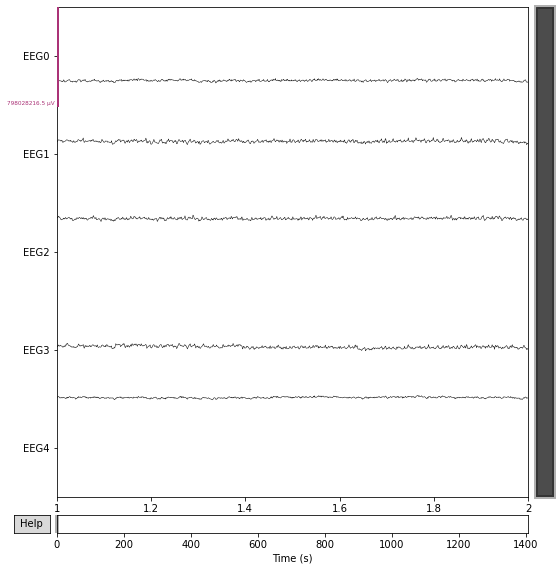

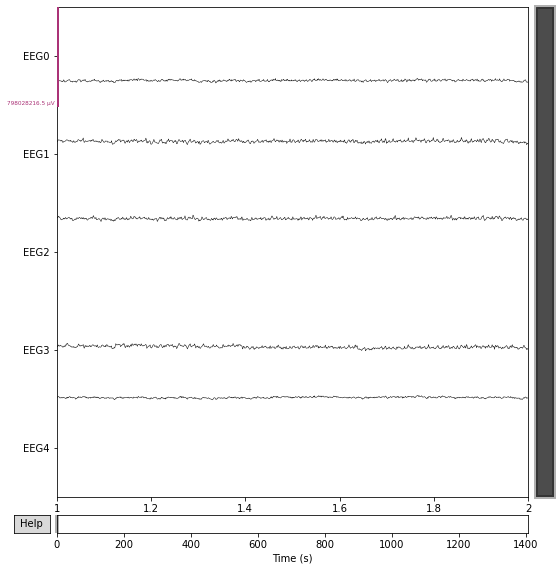

In [9]:
my_raw.plot(start=1, duration=1, remove_dc=False, scalings='auto')

In [15]:
print('data_info', data_info)

data_info {'exp1_duration': 1408.704, 'exp1_chnum': 5, 'exp1_filename': '3'}


In [119]:
csv_path = '../csv_0428'

csv_list = os.listdir(csv_path)
csv_list.sort()
print('csv_list', csv_list)

csv_list ['093433_上杉佳10772010.xls', '111744_杨玉娟10117424.xls', '115536_邹琦飞10381836.xls', '123110_刘宏11299760.xls']


In [120]:
df = pd.read_excel('{}/{}'.format(csv_path, csv_list[0]))
# df = df.T
# df.drop([0])
df

,名称,09:29,09:30,09:31,09:32,09:33,09:34,09:35,09:36,09:37,...,09:52,09:53,09:54,09:55,09:56,09:57,09:58,09:59,10:00,10:01
0,心率,89.0,81.0,78.0,74.0,76.0,74.0,74.0,86,79.0,...,64.0,67,61,66.0,62.0,63.0,64.0,67.0,69.0,63.0
1,PULSE,89.0,81.0,78.0,74.0,76.0,74.0,74.0,86,79.0,...,64.0,67,61,66.0,62.0,63.0,64.0,67.0,69.0,63.0
2,中心静脉压,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,呼吸,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SpO2,98.0,99.0,99.0,100.0,100.0,100.0,100.0,100,100.0,...,98.0,100,100,100.0,100.0,100.0,100.0,99.0,98.0,98.0
5,ETCO2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FiO2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,无创收缩压,0.0,0.0,0.0,0.0,0.0,139.0,139.0,127,127.0,...,130.0,130,138,138.0,138.0,138.0,138.0,138.0,146.0,146.0
8,无创舒张压,0.0,0.0,0.0,0.0,0.0,80.0,80.0,85,85.0,...,72.0,72,78,78.0,78.0,79.0,79.0,79.0,67.0,47.0
9,体温,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df.keys()

Index(['名称', '09:29', '09:30', '09:31', '09:32', '09:33', '09:34', '09:35',
       '09:36', '09:37', '09:38', '09:39', '09:40', '09:41', '09:42', '09:43',
       '09:44', '09:45', '09:46', '09:47', '09:48', '09:49', '09:50', '09:51',
       '09:52', '09:53', '09:54', '09:55', '09:56', '09:57', '09:58', '09:59',
       '10:00', '10:01'],
      dtype='object')

In [121]:
time_num = len(df.keys()) - 1
print('time_num', time_num)

time_num 33


In [122]:
time_inject = 0
time_wake = 0
time_eyelash = 0
for i in range(1, time_num):
    if df.iloc[14, i] == '诱导给药':
        time_inject = i
    if df.iloc[14, i] == '唤醒':
        time_wake = i
    if df.iloc[14, i] == '睫毛反射恢复':
        time_eyelash = i
print('time_inject', time_inject)
print('time_wake', time_wake)
print('time_eyelash', time_eyelash)

time_inject 8
time_wake 26
time_eyelash 25


In [123]:
bis_start = 0
for i in range(1, time_num):
    if not np.isnan(df.iloc[12, i]):
        bis_start = i
        break
print('bis_start', bis_start)

bis_start 5


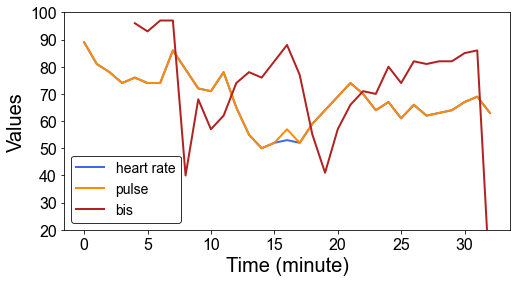

In [130]:
color_bkp = ['forestgreen', 'darkorange',  'dimgray',
                'limegreen', 'royalblue', 'darkgrey', 'forestgreen', 'darkblue', 'purple']
colors = ['royalblue', 'darkorange', 'firebrick', 'forestgreen']

plt.figure(figsize=(8,4))
heart_rate = np.array(list(map(int, df.iloc[0, 1:].tolist())))
plt.plot(np.arange(time_num), heart_rate, label='heart rate', color=colors[0], lw=2)
# plt.show()

pulse = np.array(list(map(int, df.iloc[1, 1:].tolist())))
plt.plot(np.arange(time_num), pulse, label='pulse', color=colors[1], lw=2)
# plt.show()

bis = np.array(list(map(int, df.iloc[12, bis_start:].tolist())))
plt.plot(np.arange(time_num-(bis_start-1))+(bis_start-1), bis, label='bis', color=colors[2], lw=2)

plt.ylim(20,100)
plt.xticks(font={'family':'Arial', 'size':16})
plt.yticks(font={'family':'Arial', 'size':16})
plt.xlabel('Time (minute)', font={'family':'Arial', 'size':20})
plt.ylabel('Values', font={'family':'Arial', 'size':20})

plt.legend(edgecolor='k', prop={'family':'Arial', 'size':14})
plt.show()

In [141]:
# eeg segment
# 将EEG切分成60s的片段
def eeg_segment(eeg_data, fs, seg_length):
    seg_points = seg_length * fs
    seg_num = eeg_data.shape[1] // seg_points
    eeg_data = eeg_data[:, 0:seg_points*seg_num]
    # eeg_data = eeg_data.reshape((len(label), eeg_data.shape[0], -1))
    eeg_data_seg = eeg_data.reshape((eeg_data.shape[0], -1, seg_points))
#     print('eeg_data.shape', eeg_data.shape)
    eeg_data_seg = eeg_data_seg.transpose(1,0,2)
    print('eeg_data_seg.shape', eeg_data_seg.shape)
    return eeg_data_seg
eeg_data = eeg_segment(eeg, fs, seg_length=1)


eeg_data_seg.shape (1408, 5, 1000)


pe.shape (1408, 5)


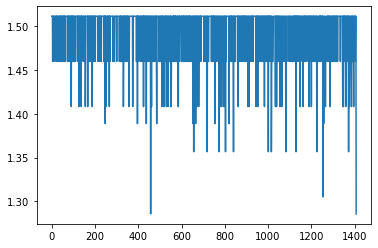

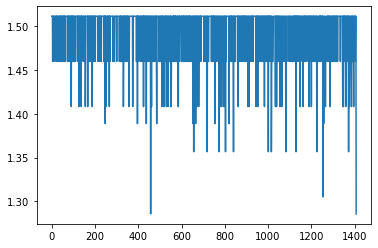

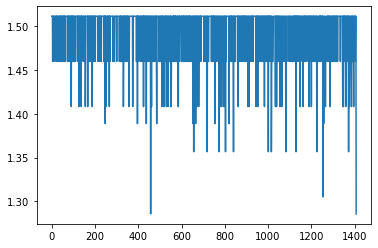

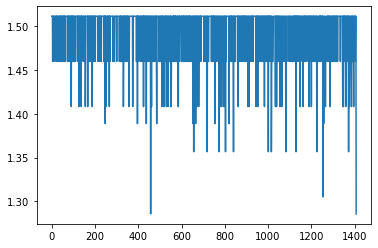

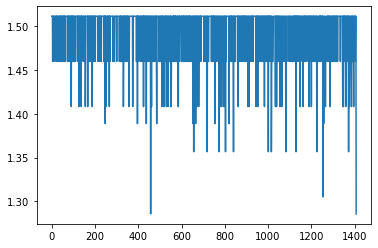

In [143]:
# Permutation entropy
pe = np.zeros((eeg_data.shape[0], eeg_data.shape[1]))
for i in range(eeg_data.shape[0]):
    pe[i,:] = ant.perm_entropy(eeg_data[i,:,:], normalize=True)
print('pe.shape', pe.shape)
for i in range(pe.shape[1]):
    plt.plot(pe[:,i])
    plt.show()
pe = pe.reshape(())

In [ ]:
# entropy features

# Permutation entropy
print('PE = ', ant.perm_entropy(x, normalize=True))

# Approximate entropy
print('AE = ', ant.app_entropy(x))

# Sample entropy
print('SE = ', ant.sample_entropy(x))

In [79]:
data_info

{'exp1_duration': 1408.704, 'exp1_chnum': 5, 'exp1_filename': '3'}

In [78]:
eeg.shape

(5, 1408704)